In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import networkx as nx
import leidenalg as la
import igraph as ig
import sys
import glob
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [19]:
pg = "../data/07-clustered-graphs/alpha0.3_k20_res0.006.graphml"
G = nx.read_graphml(pg)
pdf = "../data/06-clustered-df/alpha0.3_k20_res0.006.pkl"
df = pd.read_pickle(pdf)

pcd = (
    "../output/tables/cluster-explorer/old/SingleSolExplorer_alpha0.3_k20_res0.006.xlsx"
)
# first sheet is the cluster details
cluster_details = pd.read_excel(pcd, sheet_name=0)

In [20]:
df.columns

Index(['api_url', 'scopus_id', 'eid', 'title', 'first_author', 'journal',
       'date', 'abstract', 'citedby_count', 'publication_type',
       'publication_subtype', 'publication_subtype_description',
       'author_count', 'authors_json', 'authkeywords', 'funding_no',
       'openaccess', 'openaccess_flag', 'doi', 'pubmed_id', 'freetoread',
       'freetoread_label', 'fund_acr', 'fund_sponsor', 'article_number',
       'year', 'auth_year', 'unique_auth_year', 'reference_eids',
       'nr_references', 'filtered_reference_eids', 'nr_filtered_references',
       'title_abstract', 'clean_title', 'clean_abstract',
       'specter2_embeddings', 'cluster_alpha0.3_k20_res0.006',
       'centrality_alpha0.3_k20_res0.006'],
      dtype='object')

# VISUALS


In [22]:
def process_given_labels(summary_df, words_to_remove, n_words=5):
    cols = [col for col in summary_df.columns if col.startswith("Word_")]
    cols = cols[:n_words]
    summary_df["Given Label"] = summary_df[cols].apply(
        lambda row: "; ".join(list(set(row.values))), axis=1
    )
    # add cluster number to the given label
    summary_df["Given Label"] = summary_df[["Cluster", "Given Label"]].apply(
        lambda row: f"{str(row['Cluster'])}: {row['Given Label']}", axis=1
    )
    givenlabel = []
    for label in summary_df["Given Label"]:
        label = [word for word in label[:10] if word not in words_to_remove]
        givenlabel.append(label)
        # print(label)
    # summary_df["Given Label"] = givenlabel

    return summary_df


words_to_remove = [
    "depression",
    "fluoxetine",
    "effects",
    "effect",
    "escitalopram",
    "paroxetine",
    "fluvoxamine",
    "citalopram",
]

summary_df = process_given_labels(cluster_details, words_to_remove, n_words=3)
cluster_label_dict = dict(zip(summary_df["Cluster"], summary_df["Given Label"]))

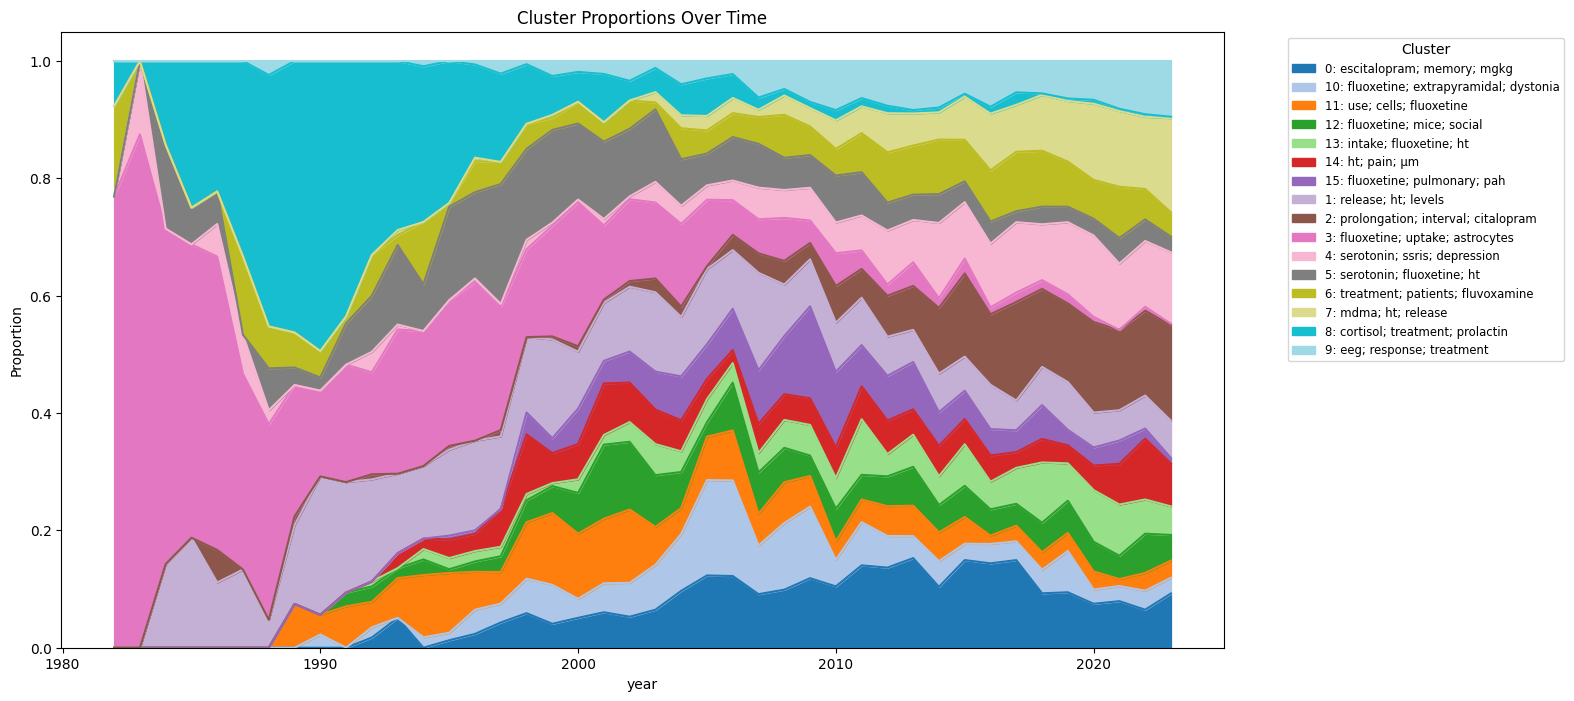

In [23]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_cluster_proportions(
    df,
    year_col,
    cluster_col,
    cluster_range=[0, 10],
    figsize=(10, 6),
    cluster_label_dict=None,
    return_df=False,
):
    """
    Visualizes the proportions of clusters over time, grouping the n smallest clusters into 'other'.

    Args:
    df (pd.DataFrame): DataFrame containing the data
    year_col (str): Name of the column containing the year
    cluster_col (str): Name of the column containing the cluster labels
    cluster_range (list): Range of clusters to include in the plot. Default is [0, 10].
    figsize (tuple): Size of the figure. Default is (10, 6).
    cluster_label_dict (dict): Dictionary mapping cluster labels to custom names. Default is None.

    Returns:
    None
    """

    # Identify smallest clusters to group into 'other'
    clusters_to_remove = [
        cluster
        for cluster in df[cluster_col].unique()
        if cluster not in range(cluster_range[0], cluster_range[1] + 1)
    ]

    # Aggregate counts per year and cluster
    cluster_counts = (
        df.groupby([year_col, cluster_col]).size().reset_index(name="count")
    )

    # Remove smallest clusters
    cluster_counts = cluster_counts[
        ~cluster_counts[cluster_col].isin(clusters_to_remove)
    ]

    # Calculate total counts per year for normalization
    yearly_totals = cluster_counts.groupby(year_col)["count"].transform("sum")

    # Calculate proportion
    cluster_counts["proportion"] = cluster_counts["count"] / yearly_totals

    # Apply cluster labels if a dictionary is provided
    if cluster_label_dict:
        cluster_counts["cluster_label"] = (
            cluster_counts[cluster_col].map(cluster_label_dict).fillna("Other")
        )
    else:
        # Default behavior if no dictionary is provided
        cluster_counts["cluster_label"] = cluster_counts[cluster_col]

    # Pivot data for plotting
    pivot_df = cluster_counts.pivot(
        index=year_col, columns="cluster_label", values="proportion"
    ).fillna(0)

    # Plot
    pivot_df.plot(kind="area", stacked=True, figsize=figsize, colormap="tab20")
    plt.ylabel("Proportion")
    plt.title("Cluster Proportions Over Time")
    plt.legend(
        title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small"
    )
    # plt.tight_layout()  # Adjust layout to make room for the legend

    plt.show()

    if return_df:
        return pivot_df


# Example usage
# Ensure you define cluster_label_dict as per your data's need before using it.
pivot_df = plot_cluster_proportions(
    df,
    "year",
    "cluster_alpha0.3_k20_res0.006",
    [0, 15],
    (15, 8),
    cluster_label_dict,
    True,
)

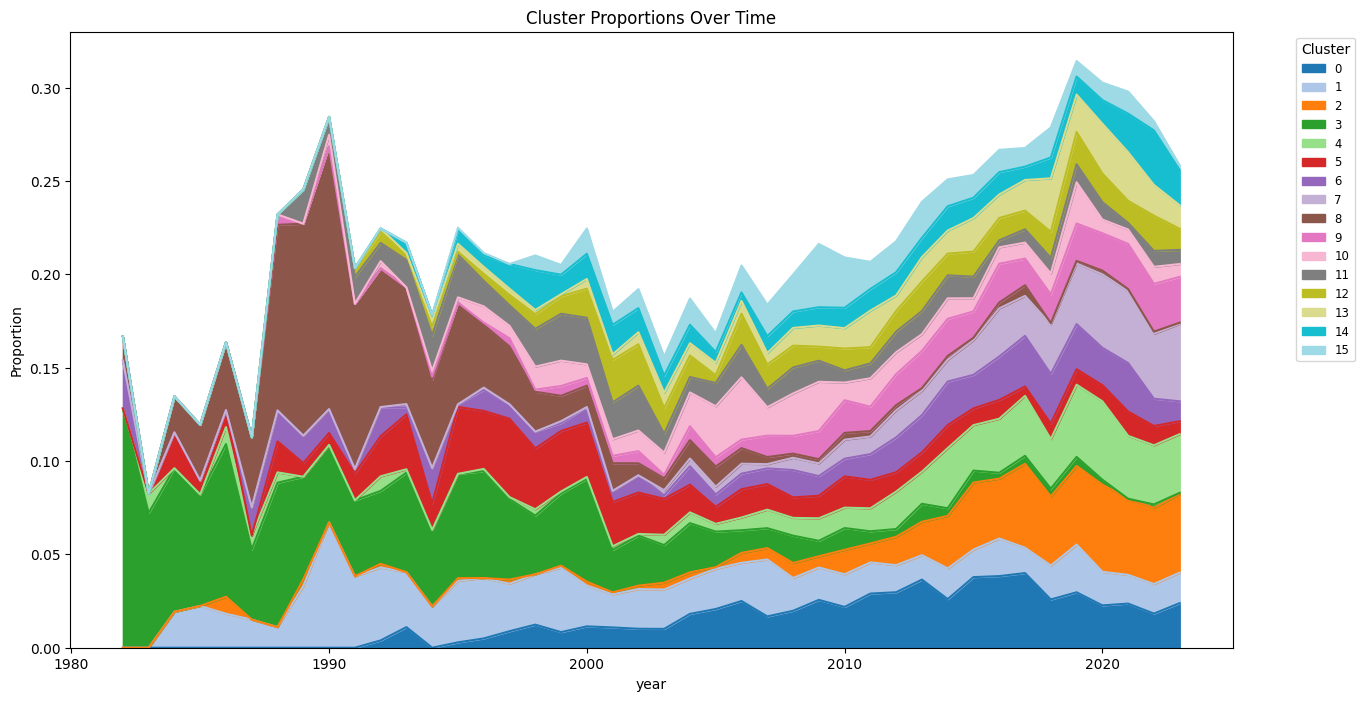

In [60]:
import matplotlib.pyplot as plt


class InteractiveProportionsPlotter:
    def __init__(
        self, df, cluster_col="cluster_alpha0.3_k20_res0.006", year_col="year"
    ):
        self.df = df
        self.cluster_col = cluster_col
        self.year_col = year_col

    def cluster_paper_quant_proportions(self, return_df=False):
        """
        This creates a df in long format with the counts of papers per cluster per year.
        """
        self.cluster_counts = (
            self.df.groupby([self.year_col, self.cluster_col])
            .size()
            .reset_index(name="count")
        )
        cluster_proportions = self.cluster_counts.groupby(self.year_col)[
            "count"
        ].transform("sum")

        self.cluster_counts["proportion"] = (
            self.cluster_counts["count"] / cluster_proportions
        )

        if return_df:
            return self.cluster_counts

    def drop_down_data(self):
        """
        This creates a dictionary with the data for the drop down menu.
        """
        clusters = self.cluster_counts[self.cluster_col].unique()
        drop_down_data_dict = {f"cluster_{cluster}": cluster for cluster in clusters}
        return drop_down_data_dict

    def plot_cluster_proportions(self, clusters_to_plot: list, normalize_overall=True):
        """
        Plots the cluster proportions over time. Can normalize against overall totals or subset totals.

        Args:
        clusters_to_plot (list): List of clusters to plot.
        normalize_overall (bool): If True, normalizes against the total of all clusters. If False, normalizes against the total of the selected subset.
        """
        if normalize_overall:
            # Use overall proportions
            filtered_cluster_counts = self.cluster_counts.copy()
        else:
            # Calculate proportions for the selected subset
            filtered_cluster_counts = self.cluster_counts[
                self.cluster_counts[self.cluster_col].isin(clusters_to_plot)
            ]
            subset_proportions = filtered_cluster_counts.groupby(self.year_col)[
                "count"
            ].transform("sum")
            filtered_cluster_counts["proportion"] = (
                filtered_cluster_counts["count"] / subset_proportions
            )

        pivot_df = filtered_cluster_counts.pivot(
            index=self.year_col, columns=self.cluster_col, values="proportion"
        ).fillna(0)

        # Plot only the selected clusters
        pivot_df = pivot_df[clusters_to_plot]

        pivot_df.plot(kind="area", stacked=True, figsize=(15, 8), colormap="tab20")
        plt.ylabel("Proportion")
        plt.title("Cluster Proportions Over Time")
        plt.legend(
            title="Cluster",
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            fontsize="small",
        )
        plt.show()


# Example usage
ipp = InteractiveProportionsPlotter(df)  # Assuming 'df' is your DataFrame
ipp.cluster_paper_quant_proportions(return_df=True)
# Use the 'normalize_overall' parameter to switch between normalization modes
ipp.plot_cluster_proportions(
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], normalize_overall=True
)

In [63]:
import pandas as pd
import plotly.express as px


class InteractiveProportionsPlotter:
    def __init__(
        self, df, cluster_col="cluster_alpha0.3_k20_res0.006", year_col="year"
    ):
        self.df = df
        self.cluster_col = cluster_col
        self.year_col = year_col

    def cluster_paper_quant_proportions(self, return_df=False):
        """
        This creates a df in long format with the counts of papers per cluster per year.
        """
        self.cluster_counts = (
            self.df.groupby([self.year_col, self.cluster_col])
            .size()
            .reset_index(name="count")
        )
        cluster_proportions = self.cluster_counts.groupby(self.year_col)[
            "count"
        ].transform("sum")
        self.cluster_counts["proportion"] = (
            self.cluster_counts["count"] / cluster_proportions
        )

        if return_df:
            return self.cluster_counts

    def plot_cluster_proportions(
        self, clusters_to_plot: list, normalize_overall=True, figsize=(15, 8)
    ):
        """
        Plots the cluster proportions over time using Plotly for interactivity. Can normalize against overall totals or subset totals.

        Args:
        clusters_to_plot (list): List of clusters to plot.
        normalize_overall (bool): If True, normalizes against the total of all clusters. If False, normalizes against the total of the selected subset.
        figsize (tuple): Size of the figure in inches, converted to pixels for Plotly.
        """
        if normalize_overall:
            filtered_cluster_counts = self.cluster_counts.copy()
        else:
            filtered_cluster_counts = self.cluster_counts[
                self.cluster_counts[self.cluster_col].isin(clusters_to_plot)
            ]
            subset_proportions = filtered_cluster_counts.groupby(self.year_col)[
                "count"
            ].transform("sum")
            filtered_cluster_counts["proportion"] = (
                filtered_cluster_counts["count"] / subset_proportions
            )

        filtered_cluster_counts = filtered_cluster_counts[
            filtered_cluster_counts[self.cluster_col].isin(clusters_to_plot)
        ]

        # Convert to "long" format suitable for Plotly
        long_df = filtered_cluster_counts.melt(
            id_vars=[self.year_col, self.cluster_col],
            value_vars="proportion",
            var_name="Metric",
            value_name="Value",
        )

        # Create Plotly figure
        fig = px.area(
            long_df,
            x=self.year_col,
            y="Value",
            color=self.cluster_col,
            title="Cluster Proportions Over Time",
            labels={"Value": "Proportion"},
            width=figsize[0] * 100,  # Plotly figsize is in pixels
            height=figsize[1] * 100,
        )

        fig.show()


ipp = InteractiveProportionsPlotter(df)
ipp.cluster_paper_quant_proportions(return_df=True)
ipp.plot_cluster_proportions(
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], normalize_overall=True
)

In [53]:
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px


def plot_cluster_proportions_plotly(
    df,
    year_col,
    cluster_col,
    cluster_range=[0, 10],
    figsize=(10, 6),
    cluster_label_dict=None,
):
    """
    Visualizes the proportions of clusters over time using Plotly for interactivity,
    grouping the n smallest clusters into 'other'.

    Args:
    df (pd.DataFrame): DataFrame containing the data.
    year_col (str): Name of the column containing the year.
    cluster_col (str): Name of the column containing the cluster labels.
    cluster_range (list): Range of clusters to include in the plot. Default is [0, 10].
    figsize (tuple): Size of the figure (width, height) in Plotly format. Default is (10, 6).
    cluster_label_dict (dict): Dictionary mapping cluster labels to custom names. Default is None.

    Returns:
    None
    """

    # Aggregate counts per year and cluster
    cluster_counts = (
        df.groupby([year_col, cluster_col]).size().reset_index(name="count")
    )

    # Filter clusters based on the provided range
    if cluster_label_dict is not None:
        cluster_counts[cluster_col] = (
            cluster_counts[cluster_col].map(cluster_label_dict).fillna("Other")
        )
    else:
        cluster_counts = cluster_counts[
            cluster_counts[cluster_col].between(
                cluster_range[0], cluster_range[1], inclusive=True
            )
        ]

    # Calculate total counts per year for normalization
    yearly_totals = cluster_counts.groupby(year_col)["count"].transform("sum")

    # Calculate proportion
    cluster_counts["proportion"] = cluster_counts["count"] / yearly_totals

    # Pivot data for plotting
    pivot_df = cluster_counts.pivot(
        index=year_col, columns=cluster_col, values="proportion"
    ).fillna(0)

    # Convert to long format for Plotly
    long_df = pivot_df.reset_index().melt(
        id_vars=[year_col], var_name="Cluster", value_name="Proportion"
    )

    # Create Plotly figure
    fig = px.area(
        long_df,
        x=year_col,
        y="Proportion",
        color="Cluster",
        title="Cluster Proportions Over Time",
        labels={"Proportion": "proportion", year_col: "Year"},
        width=figsize[0] * 100,
        height=figsize[1] * 100,
    )  # Plotly figsize is in pixels

    fig.show()


# Example usage
# Ensure you define df, cluster_label_dict as per your data's need before using it.
# df should be your DataFrame containing the relevant columns.
# cluster_label_dict = {0: "Cluster 0", 1: "Cluster 1", ...} # example cluster_label_dict
plot_cluster_proportions_plotly(
    df, "year", "cluster_alpha0.3_k20_res0.006", [0, 15], (15, 8), cluster_label_dict
)

In [27]:
import pandas as pd
import plotly.graph_objs as go


def plot_cluster_proportions_with_dropdown(
    df,
    year_col,
    cluster_col,
    cluster_range=[0, 10],
    figsize=(10, 6),
    cluster_label_dict=None,
):
    """
    Visualizes the proportions of clusters over time, grouping the n smallest clusters into 'other',
    with an interactive dropdown menu for selecting which clusters to display.

    Args:
    df (pd.DataFrame): DataFrame containing the data
    year_col (str): Name of the column containing the year
    cluster_col (str): Name of the column containing the cluster labels
    cluster_range (list): Range of clusters to include in the plot. Default is [0, 10].
    figsize (tuple): Size of the figure. Default is (10, 6).
    cluster_label_dict (dict): Dictionary mapping cluster labels to custom names. Default is None.

    Returns:
    plotly.graph_objs._figure.Figure: Interactive Plotly figure with a dropdown menu for cluster selection.
    """

    # Preprocess DataFrame
    df_filtered = df[
        (df[cluster_col] >= cluster_range[0]) & (df[cluster_col] <= cluster_range[1])
    ]
    if cluster_label_dict:
        df_filtered[cluster_col] = df_filtered[cluster_col].apply(
            lambda x: cluster_label_dict.get(x, "Other")
        )

    # Calculate proportions
    total_counts = df_filtered.groupby([year_col]).size().rename("Total").reset_index()
    cluster_counts = (
        df_filtered.groupby([year_col, cluster_col])
        .size()
        .rename("Count")
        .reset_index()
    )
    proportions = pd.merge(cluster_counts, total_counts, on=year_col)
    proportions["Proportion"] = proportions["Count"] / proportions["Total"]

    # Create Plotly figure
    fig = go.Figure()

    # Add traces
    clusters = proportions[cluster_col].unique()
    for cluster in clusters:
        cluster_data = proportions[proportions[cluster_col] == cluster]
        fig.add_trace(
            go.Scatter(
                x=cluster_data[year_col],
                y=cluster_data["Proportion"],
                mode="lines",
                name=str(cluster),
                visible=True,
            )
        )

    # Add dropdown
    dropdown_buttons = []
    for cluster in clusters:
        dropdown_buttons.append(
            {
                "label": str(cluster),
                "method": "update",
                "args": [
                    {"visible": [c == cluster for c in clusters]},
                    {"title": f"Cluster {cluster} Proportions Over Time"},
                ],
            }
        )
    # Button for showing all clusters
    dropdown_buttons.append(
        {
            "label": "All",
            "method": "update",
            "args": [
                {"visible": [True] * len(clusters)},
                {"title": "All Cluster Proportions Over Time"},
            ],
        }
    )

    fig.update_layout(
        updatemenus=[
            {
                "type": "dropdown",
                "x": 1.3,
                "y": 0.5,
                "showactive": True,
                "active": len(clusters),
                "buttons": dropdown_buttons,
            }
        ],
        title="Cluster Proportions Over Time",
        xaxis_title=year_col,
        yaxis_title="Proportion",
        width=figsize[0] * 100,  # Convert figsize to pixels for Plotly
        height=figsize[1] * 100,
    )

    fig.show()


# Replace `df`, `year_col`, `cluster_col`, `cluster_range`, `figsize`, and `cluster_label_dict` with your actual parameters.
# Example usage:
plot_cluster_proportions_with_dropdown(
    df,
    "year",
    "cluster_alpha0.3_k20_res0.006",
    [0, 10],
    (10, 6),
    {1: "Cluster 1", 2: "Cluster 2"},
)

/var/folders/6m/zjbwrdgj0bg9zyhx3l7134mm0000gn/T/ipykernel_26031/1942916532.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Sonification

- Piano: 0-7 (e.g., Acoustic Grand Piano is 0)
- Chromatic Percussion: 8-15 (e.g., Music Box is 10)
- Organ: 16-23 (e.g., Church Organ is 19)
- Guitar: 24-31 (e.g., Acoustic Guitar (nylon) is 24)
- Bass: 32-39 (e.g., Electric Bass (finger) is 33)
- Strings: 40-47 (e.g., Violin is 40, String Ensemble 1 is 48)
- Ensemble: 48-55 (e.g., String Ensemble 1 is 48)
- Brass: 56-63 (e.g., Trumpet is 56)
- Reed: 64-71 (e.g., Soprano Sax is 64)
- Pipe: 72-79 (e.g., Oboe is 68)
- Synth Lead: 80-87 (e.g., Lead 1 (square) is 80)
- Synth Pad: 88-95 (e.g., Pad 1 (new age) is 88)
- Synth Effects: 96-103
- Ethnic: 104-111 (e.g., Sitar is 104)
- Percussive: 112-119 (e.g., Steel Drums is 114)
- Sound Effects: 120-127 (e.g., Helicopter is 125)


In [16]:
pdf = pivot_df.reset_index(drop=True)
pdf.columns = [name.split(";", 1)[0] if ";" in name else name for name in pdf.columns]
pdf.iloc[0:5, 0:5]

0: impairment  10: myoclonus  11: sertraline  12: brain  13: reuptake
0            0.0            0.0             0.0        0.0           0.0
1            0.0            0.0             0.0        0.0           0.0
2            0.0            0.0             0.0        0.0           0.0
3            0.0            0.0             0.0        0.0           0.0
4            0.0            0.0             0.0        0.0           0.0

In [17]:
from midiutil import MIDIFile
import pandas as pd
import numpy as np


def create_sonified_midi(
    pdf,
    column_name="3: astrocytes",
    min_pitch=60,
    max_pitch=127,
    volume_range=(70, 127),
    filename="sonified_data.mid",
    instrument=0,
):
    """
    Create a MIDI file from a DataFrame's values, mapping data to pitch and volume.

    Parameters:
    - pdf: DataFrame containing the data to be sonified.
    - column_name: The column in the DataFrame to be used for sonification.
    - min_pitch: The minimum pitch value for the lowest data point (default 60).
    - max_pitch: The maximum pitch value for the highest data point (default 127).
    - volume_range: A tuple representing the minimum and maximum volume (default (70, 127)).
    - filename: The name of the output MIDI file (default "sonified_data.mid").
    """
    midi_file = MIDIFile(1)  # Create a new MIDI file with one track
    track = 0
    time = 0
    midi_file.addTrackName(track, time, "Track")
    midi_file.addTempo(track, time, 120)

    channel = 0
    instrument = instrument  # Set to your desired instrument
    midi_file.addProgramChange(track, channel, time, instrument)

    duration = 0.5  # Duration of each note in beats

    for index, row in pdf.iterrows():
        # Map the data value to the pitch range
        data_value = row[column_name]
        if data_value > 0:
            pitch = max(
                int(np.interp(data_value, [0, 1], [min_pitch, max_pitch])), min_pitch
            )
        else:
            continue  # Skip rows with 0 or negative values

        # Map the data value to the volume range
        volume = int(np.interp(data_value, [0, 1], volume_range))

        midi_file.addNote(track, channel, pitch, time, duration, volume)
        time += duration
        # print(volume)
    # Write to disk
    with open(filename, "wb") as output_file:
        midi_file.writeFile(output_file)
    print(f"MIDI file '{filename}' has been created.")

In [18]:
# Assuming you have a DataFrame named 'pdf' ready
# pdf = pd.DataFrame({'0: memory': np.random.rand(10)})  # Example, replace with your DataFrame

create_sonified_midi(
    pdf,
    column_name="3: astrocytes",
    min_pitch=30,
    max_pitch=127,
    volume_range=(50, 127),
    filename="enhanced_sonified_data.mid",
    instrument=0,
)

KeyError: '3: astrocytes'

In [ ]:
import os
from midi2audio import FluidSynth
from IPython.display import Audio

# Convert MIDI to WAV using FluidSynth
soundfont = "/Users/jlq293/Projects/sound/GeneralUser GS 1.471/GeneralUser GS v1.471.sf2"  # Update with the path to your soundfont file
midi_file = (
    "/Users/jlq293/Projects/Study-1-Bibliometrics/notebooks/enhanced_sonified_data.mid"
)
wav_file = "sonified_data.wav"

# Initialize FluidSynth with the soundfont
fs = FluidSynth(soundfont)

# Convert MIDI to WAV
fs.midi_to_audio(midi_file, wav_file)

# Play the WAV file
Audio(wav_file)

FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'sonified_data.wav'..


In [ ]:
f